In [3]:
# !pip install colorcorrect

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

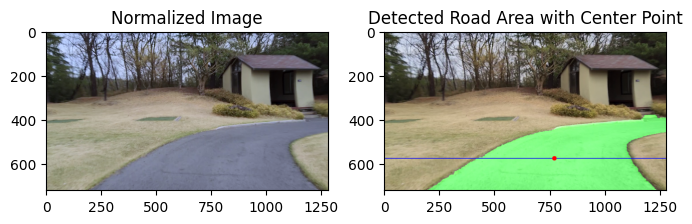

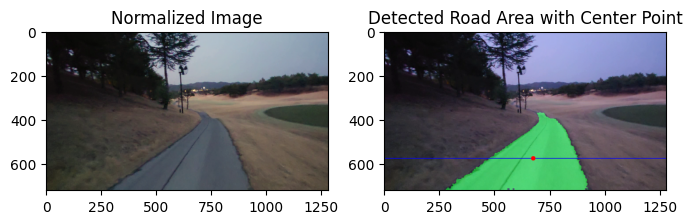

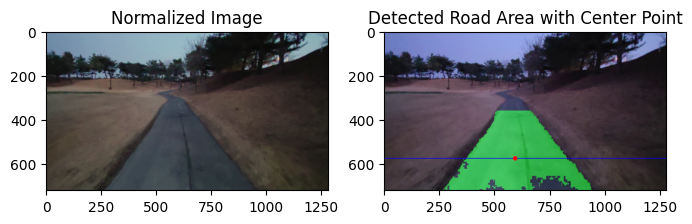

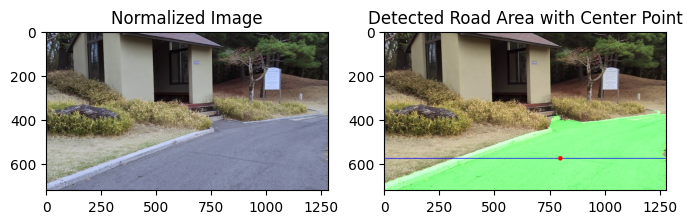

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def fast_gray_world_normalization(image):
    img = image.astype(np.float32)
    avg_b = np.mean(img[:, :, 0])
    avg_g = np.mean(img[:, :, 1])
    avg_r = np.mean(img[:, :, 2])

    avg_gray = (avg_b + avg_g + avg_r) / 3

    img[:, :, 0] = np.clip((img[:, :, 0] * (avg_gray / avg_b)), 0, 255)
    img[:, :, 1] = np.clip((img[:, :, 1] * (avg_gray / avg_g)), 0, 255)
    img[:, :, 2] = np.clip((img[:, :, 2] * (avg_gray / avg_r)), 0, 255)

    return img.astype(np.uint8)

def process_image(image_path):
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error loading image: {image_path}")
        return

    # Normalize image using gray world assumption
    normalized_image = fast_gray_world_normalization(image)

    # Convert to HSV
    hsv_image = cv2.cvtColor(normalized_image, cv2.COLOR_BGR2HSV)
    height, width, _ = hsv_image.shape
    roi = hsv_image[height // 2:, :]  # Focus on the bottom half

    # Extract hue channel and create a mask for the road area
    hue_channel = roi[:, :, 0]
    lower_hue = 100
    upper_hue = 130
    road_mask_roi = cv2.inRange(hue_channel, lower_hue, upper_hue)

    # Create the full mask with the lower half of the image processed
    road_mask_full = np.zeros((height, width), dtype=np.uint8)
    road_mask_full[height // 2:, :] = road_mask_roi

    # Morphological operations to remove noise
    kernel = np.ones((5, 5), np.uint8)
    morphed_mask = cv2.morphologyEx(road_mask_full, cv2.MORPH_CLOSE, kernel)

    # Find contours and keep only the largest one
    contours, _ = cv2.findContours(morphed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        morphed_mask = np.zeros_like(morphed_mask)
        cv2.drawContours(morphed_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # Create a green overlay to highlight the selected road area
    green_overlay = np.zeros_like(image)
    green_overlay[:, :, 1] = 255  # Make it green
    green_overlay = cv2.bitwise_and(green_overlay, green_overlay, mask=morphed_mask)

    # Combine the green overlay with the original image
    overlay_image = cv2.addWeighted(image, 1, green_overlay, 0.5, 0)

    # Horizontal line at 1/5th from the bottom of the image
    line_y = int(height * 4 / 5)  # Adjust to 1/5th from the bottom
    horizontal_line_mask = morphed_mask[line_y, :]  # Mask values at that horizontal line

    # Find the left-most and right-most points on the selected area along the line
    left_point = np.argmax(horizontal_line_mask > 0)
    right_point = width - np.argmax(np.flip(horizontal_line_mask) > 0)

    # If no points are found on the line, use the center of the line and show a yellow circle
    if np.sum(horizontal_line_mask) == 0:
        center_point = width // 2
        circle_color = (0, 255, 255)  # Yellow color
    else:
        center_point = (left_point + right_point) // 2
        circle_color = (0, 0, 255)  # Red color

    # Draw a blue horizontal line
    cv2.line(overlay_image, (0, line_y), (width, line_y), (255, 0, 0), 2)

    # Draw the circle (yellow if no points, red otherwise) with radius 10
    cv2.circle(overlay_image, (center_point, line_y), 10, circle_color, -1)

    # Display the results using matplotlib
    plt.figure(figsize=(8, 6))

    plt.subplot(1, 2, 1)
    plt.title('Normalized Image')
    plt.imshow(cv2.cvtColor(normalized_image, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    plt.title('Detected Road Area with Center Point')
    plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))

    plt.show()

# Process all images in the directory
image_directory = 'test/'

for filename in os.listdir(image_directory):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        image_path = os.path.join(image_directory, filename)
        process_image(image_path)


In [7]:
### video

In [ ]:
import cv2
import numpy as np
import time

def fast_gray_world_normalization(image):
    img = image.astype(np.float32)
    avg_b = np.mean(img[:, :, 0])
    avg_g = np.mean(img[:, :, 1])
    avg_r = np.mean(img[:, :, 2])

    avg_gray = (avg_b + avg_g + avg_r) / 3

    img[:, :, 0] = np.clip((img[:, :, 0] * (avg_gray / avg_b)), 0, 255)
    img[:, :, 1] = np.clip((img[:, :, 1] * (avg_gray / avg_g)), 0, 255)
    img[:, :, 2] = np.clip((img[:, :, 2] * (avg_gray / avg_r)), 0, 255)

    return img.astype(np.uint8)

def process_video(input_video_path, output_video_path, scale_factor=0.5):
    cap = cv2.VideoCapture(input_video_path)
    original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(original_width * scale_factor)
    height = int(original_height * scale_factor)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # codec for MP4
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (original_width, original_height))

    start_time = time.time()
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        small_frame = cv2.resize(frame, (width, height))
        normalized_image = fast_gray_world_normalization(small_frame)
        hsv_image = cv2.cvtColor(normalized_image, cv2.COLOR_BGR2HSV)
        roi = hsv_image[height // 2:, :]
        hue_channel = roi[:, :, 0]
        lower_hue = 100
        upper_hue = 130
        road_mask_roi = cv2.inRange(hue_channel, lower_hue, upper_hue)
        road_mask_full = np.zeros((height, width), dtype=np.uint8)
        road_mask_full[height // 2:, :] = road_mask_roi
        kernel = np.ones((5, 5), np.uint8)
        morphed_mask = cv2.morphologyEx(road_mask_full, cv2.MORPH_CLOSE, kernel)
        contours, _ = cv2.findContours(morphed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            morphed_mask = np.zeros_like(morphed_mask)
            cv2.drawContours(morphed_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        green_overlay = np.zeros_like(small_frame) #faster
        green_overlay[:, :, 1] = 255  # Make it green
        green_overlay = cv2.bitwise_and(green_overlay, green_overlay, mask=morphed_mask)
        overlay_image = cv2.addWeighted(small_frame, 1, green_overlay, 0.5, 0)
        line_y = int(height * 4 / 5)
        horizontal_line_mask = morphed_mask[line_y, :]
        left_point = np.argmax(horizontal_line_mask > 0)
        right_point = width - np.argmax(np.flip(horizontal_line_mask) > 0)
        if np.sum(horizontal_line_mask) == 0:
            center_point = width // 2
            circle_color = (0, 255, 255)  # Yellow
        else:
            center_point = (left_point + right_point) // 2
            circle_color = (0, 0, 255)  # Red
        cv2.line(overlay_image, (0, line_y), (width, line_y), (255, 0, 0), 2)
        cv2.circle(overlay_image, (center_point, line_y), 5, circle_color, -1)
        output_frame = cv2.resize(overlay_image, (original_width, original_height))
        out.write(output_frame)

        frame_count += 1

    end_time = time.time()
    total_time = end_time - start_time
    processing_fps = frame_count / total_time

    print(f"Processed {frame_count} frames in {total_time:.2f} seconds.")
    print(f"Original video FPS: {fps}")
    print(f"Processing FPS: {processing_fps:.2f}")

    if processing_fps >= fps:
        print("Processing is realtime or faster.")
    else:
        print("Processing is slower than realtime.")

    cap.release()
    out.release()
    cv2.destroyAllWindows()

input_video_path = '20230318_184835.mp4'  
output_video_path = 'ot35.mp4'  # Output video path

# Process the video with a scale factor
process_video(input_video_path, output_video_path, scale_factor=0.5)

Processed 2392 frames in 59.37 seconds.
Original video FPS: 29.986331481288282
Processing FPS: 40.29
Processing is realtime or faster.


In [ ]:
input_video_path = '20230325_165844.mp4'  
output_video_path = 'ot844.mp4'  # Output video path

# Process the video with a scale factor
process_video(input_video_path, output_video_path, scale_factor=0.5)

Processed 2231 frames in 57.71 seconds.
Original video FPS: 29.998328197158592
Processing FPS: 38.66
Processing is realtime or faster.


In [ ]:
###